In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from math import *

import scipy as sp
import scipy.optimize

from parser import read_data

In [3]:
from matplotlib.patches import Circle, Ellipse, Rectangle
from matplotlib.collections import PatchCollection

def circles(x, y, s, c='b', **kwargs):
    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
        
    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    plt.draw_if_interactive()
    if c is not None:
        plt.sci(collection)
    return collection

0.00613713264465332 to generate 1000 population with 50 obsticles
0.17058897018432617 to simulate 1000 partitions with 50 obsticles


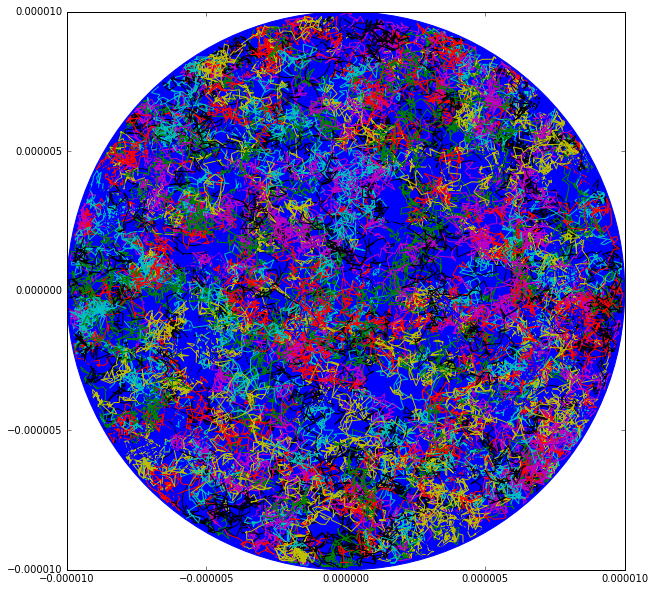

In [11]:
def to_xyz(array):
    alpha, r, h = array
    return np.array([array[1] * np.cos(array[0]), array[1] * np.sin(array[0]), h])

def generate_parametrization(size, min_r, max_r):
    if not size:
        return np.zeros((size, 4))
    
    rs = np.random.uniform(min_r, max_r, [size, 1])

    alphas = np.random.uniform(0, np.pi * 2, [size, 1])
    ps = (R - rs)**2 * np.random.uniform(0, 1, [size, 1])
    hs = np.random.uniform(rs, H - rs, [size, 1])
    
    return np.hstack([ps, alphas, hs, rs])

def parametrization_to_coords(values):
    ps = np.sqrt(values[:, 0:1])
    xs = ps * np.cos(values[:, 1:2])
    ys = ps * np.sin(values[:, 1:2])
    
    return np.hstack([xs, ys, values[:, 2:]])

def generate_points(size, min_r, max_r):
    return parametrization_to_coords(generate_parametrization(size, min_r, max_r))

def generate_population(obsticles, population_size, min_r, max_r, min_prob=0):
    population = generate_points(population_size, min_r, max_r)
    bad = filter_collisions(population, obsticles)
    population = population[np.logical_not(bad)]
    prob = sum(np.logical_not(bad)) / len(bad)

    print(prob)
    
    if prob < min_prob:
        return None, None
    
    while population.shape[0] < population_size:
        need = population_size - population.shape[0]
        estimated = ceil(1.1 * need / prob)
        
        beings = generate_points(estimated, min_r, max_r)
        bad = filter_collisions(beings, obsticles)
        beings = beings[np.logical_not(bad)]
        population = np.vstack([population, beings[:need]])
    
    return population, prob
        
def generate_population_obsticles(population_size, min_r, max_r, obsticles_count, o_min_r, o_max_r, min_prob=0):
    obsticles = generate_points(obsticles_count, o_min_r, o_max_r)
    population, _ = generate_population(obsticles, population_size, min_r, max_r, min_prob)
    return population, obsticles

def generate_displacement(population, delta_t, pre_r):
    sigmas = np.sqrt(2 * pre_r / population[:, N] * delta_t)
    return np.random.randn(population.shape[0], population.shape[1] - 1) * sigmas[:, np.newaxis]

def check_for_out_of_bounds(population):
    first = population[:, N] <= population[:, N - 1]
    second = population[:, N - 1] <= H - population[:, N]
    third = np.linalg.norm(population[:, :N - 1], axis=1) <= R - population[:, N]
    
    return np.logical_not(np.logical_and(first, np.logical_and(second, third)))

def check_for_collisions_being(being, obsticles):
    return np.linalg.norm(obsticles[:, :N] - being[:N], axis=1) ** 2 < (obsticles[:, N] + being[N]) ** 2
    
def check_for_collisions_obsticle(obsticle, population):
    return np.linalg.norm(population[:, :N] - obsticle[:N], axis=1) ** 2 < (population[:, N] + obsticle[N]) ** 2

# def filter_collisions(population, obsticles):
#     return np.any(np.apply_along_axis(check_for_collisions, 1, population, obsticles), axis=1)

def filter_collisions(population, obsticles):
    if population.shape[0] > obsticles.shape[0]:
        return np.any(np.apply_along_axis(check_for_collisions_obsticle, 1, obsticles, population), axis=0)
    else:
        return np.any(np.apply_along_axis(check_for_collisions_being, 1, population, obsticles), axis=1)

def build_tracks(population, obsticles, length, pre_r):
    tracks = np.zeros([population.shape[0], length, N])
    
    for i in range(length):
        tracks[:, i, :] = population[:, :N]
    
        deltas = generate_displacement(population, DELTA_T, pre_r)
        population[:, :N] += deltas
        need_to_revert = np.logical_or(check_for_out_of_bounds(population), filter_collisions(population, obsticles))
        population[:, :N][need_to_revert] -= deltas[need_to_revert]
        
    return tracks

def remove_same(track):
    indexes = np.hstack([[True], np.any(track[1:, :] != track[:-1, :], axis=1)]) 
    return track[indexes]

N = 3
ETA = 1.0e-3
kB = 1.38e-23
T = 293

PRE_R = kB * T / (3 * np.pi * ETA)

MIN_R = 0.5e2 * 1e-9
MAX_R = MIN_R#3e2 * 1e-9
O_MIN_R = 16 * MAX_R * 1
O_MAX_R = 16 * MAX_R * 1
R = 10 * 1e-6
H = 1.5 * 1e-5

MAX_R_COEF = preR / (2 * MIN_R)
DELTA_T = R**2 / (2 * (N - 1) * MAX_R_COEF) / 3000

PART_CNT = 1000
OBST_CNT = 50
TRACK_SIZE = 50

start_time = time.time()
population, obsticles = generate_population_obsticles(PART_CNT, MIN_R, MAX_R, OBST_CNT, O_MIN_R, O_MAX_R)
end_time = time.time()
print('{} to generate {} population with {} obsticles'
      .format(end_time - start_time, len(population), len(obsticles)))
start_time = time.time()
tracks = build_tracks(population, obsticles, TRACK_SIZE, PRE_R)
end_time = time.time()

print('{} to simulate {} partitions with {} obsticles'
      .format(end_time - start_time, PART_CNT, OBST_CNT))

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
ax.add_artist(plt.Circle((0, 0), R, color='b'))
for obsticle in obsticles:
    ax.add_artist(plt.Circle(obsticle[:N-1], obsticle[N]))
for (i, track) in enumerate(tracks):
    ax.plot(track[:, 0], track[:, 1])
#     if i > 100:
#         break
plt.savefig('./presentation/model.pdf')
plt.show()

[[  7.59902850e-01   9.36997804e-15]
 [  7.72527614e-01   4.17370658e-15]
 [  9.98571038e-01   2.32243200e-15]]
(2.3456522875277553e-07, 5.8851816740640988e-08, 0.75990285048648687, 9.3699780441561338e-15)
(4.5533895341386846e-07, 5.5080967993193539e-08, 0.77252761390658031, 4.173706584867945e-15)
(6.9413926473259157e-07, 1.2140068156746445e-07, 0.99857103773462874, 2.3224320044182776e-15)


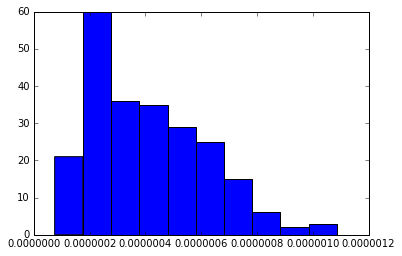

In [74]:
def low_data_std_values(coords, length_factor=1):
    xs = np.arange(1, int(coords.shape[0] * length_factor))
    ys = [np.mean([np.linalg.norm(coords[j + i, 1:] - coords[j, 1:])**2 for j in range(coords.shape[0] - i)]) for i in xs]
    return xs, ys

def large_data_std_values(tracks, length_factor=1):
    xs = np.arange(1, tracks[0].shape[0])
    ys = [np.mean(np.linalg.norm(tracks[:, i, :] - tracks[:, 0, :], axis=1)**2) for i in xs]
    return xs, ys

def t_function(x, alpha, beta):
    return beta * x**alpha

def std_to_curve_params(xs, ys, popt=[1, 1]):
    popt, _ = sp.optimize.curve_fit(t_function, xs, ys, popt)
    return popt

data = read_data()
plt.hist([np.mean(track[:, 0]) for track in data])

params = np.array([[np.mean(track[:, 0]), 
                    *std_to_curve_params(*low_data_std_values(track[:, 1:], 0.5))
                   ] for track in data])
sizes = [0, 7 * 0.05 * 1e-6, 11 * 0.05 * 1e-6, float('inf')]

r_means = []
r_stds = []
alphas = []
betas = []

for i in range(1, len(sizes)):
    indices = np.logical_and(sizes[i - 1] <= params[:, 0], params[:, 0] < sizes[i])
    
    r_means.append(np.mean(params[indices][:, 0]))
    r_stds.append(np.std(params[indices][:, 0]))
    alphas.append(np.mean(params[indices][:, 1]))
    betas.append(np.mean(params[indices][:, 2]))

target_vector = np.array(list(zip(alphas, betas)))
print(target_vector)
    
for i in zip(r_means, r_stds, alphas, betas):
    print(i)

In [76]:
print(np.linalg.norm(target_vector - 0.9 * target_vector))

0.147356553089


In [102]:
# from operator import itemgetter

def prob_penalty(prob):
    return 0 if prob > 0.15 else 1 if prob < 0.1 else 1 - (prob - 0.1) / (0.15 - 0.1)

def calculate_parameters(obsticles, pre_r, visualize=False):
    popts = []
    for r_mean, r_std in zip(r_means, r_stds):
        population, prob = generate_population(obsticles, PART_CNT, r_mean - r_std, r_mean + r_std, 0.05)
        if population is None:
            return float('Inf')
        
        tracks = build_tracks(population, obsticles, TRACK_SIZE, pre_r)
        popts.append(std_to_curve_params(*large_data_std_values(tracks)))
    
    return np.array(popts)

F_CNT = 15

def calculate_fitness(being, visualize=False):
    eta = being[0]
    pre_r = kB * T / (3 * np.pi * eta)
    obst_cnt = being[1]
    obst_params = being[2:]
    
    
    result_params = calculate_parameters(generate_points(int(obst_cnt), *obst_params), pre_r)
    for i in range(F_CNT - 1):
        result_params += calculate_parameters(generate_points(int(obst_cnt), *obst_params), pre_r)
    return np.linalg.norm(target_vector - result_params / F_CNT)**2
print(calculate_fitness([ETA, 1, 0, 0]))

0.0961598399099


110
110
Best fitness: 0.04057527602866576


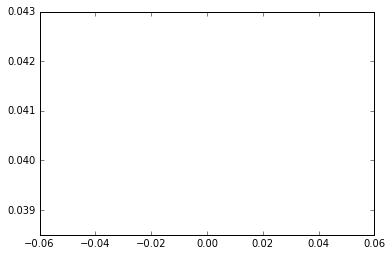

110
Best fitness: 0.04146298378721242


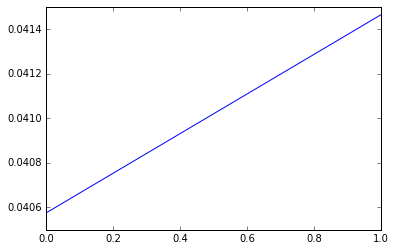

110
Best fitness: 0.03684907132695204


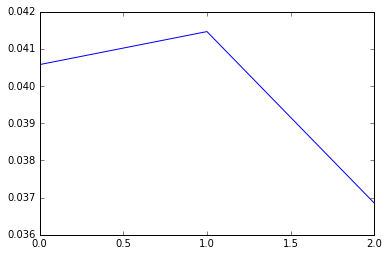

110
Best fitness: inf


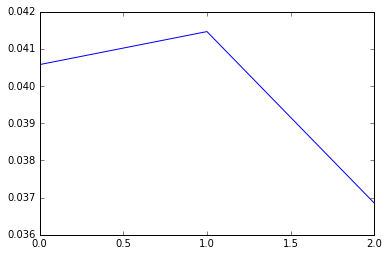

110
Best fitness: inf


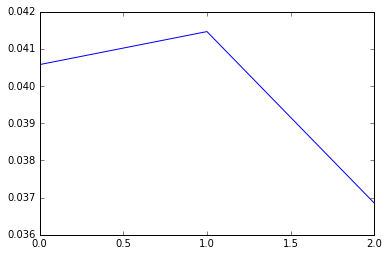

110
Best fitness: inf


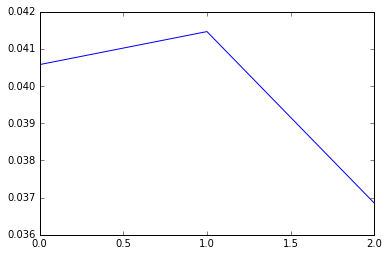

110
Best fitness: inf


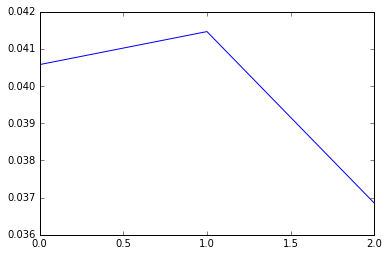

110
Best fitness: 0.0440263609932733


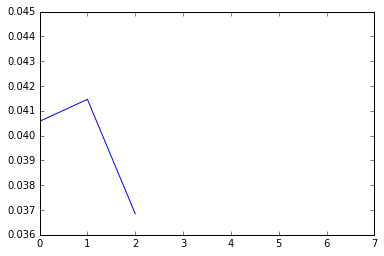

110
Best fitness: 0.041036942836764886


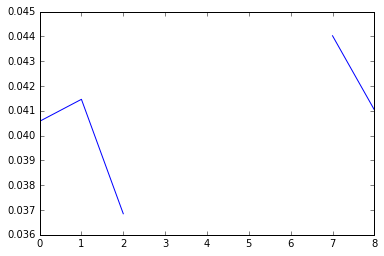

110
Best fitness: 0.03919850205330691


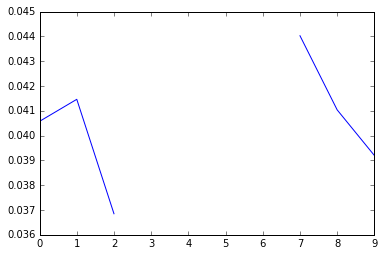

110
Best fitness: 0.040508957367891556


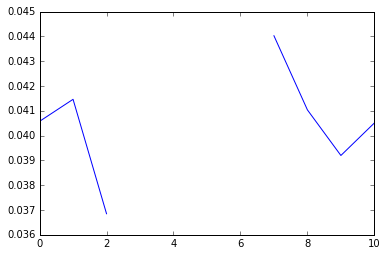

110
Best fitness: 0.04093828267821831


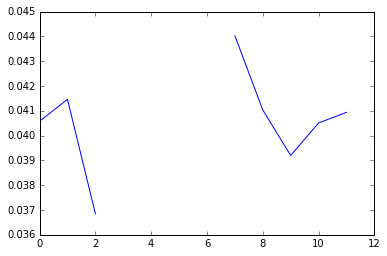

110
Best fitness: 0.03961528759089231


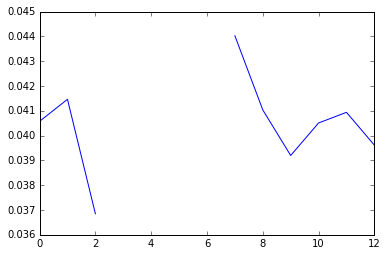

110
Best fitness: 0.041287345024050064


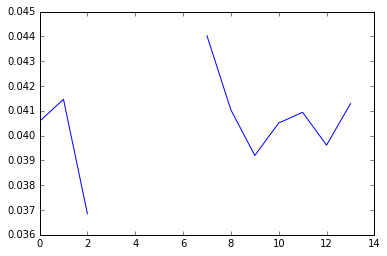

110
Best fitness: 0.039767351545376334


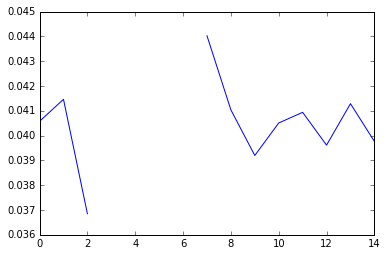

110
Best fitness: 0.039766541417309564


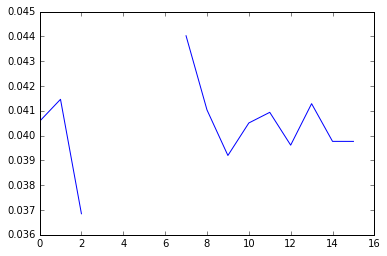

110
Best fitness: 0.041838555165293674


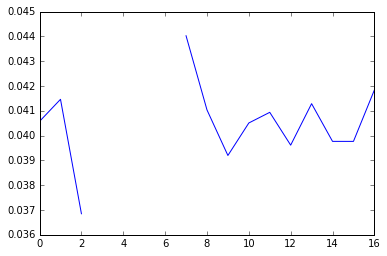

110
Best fitness: 0.0391296690603289


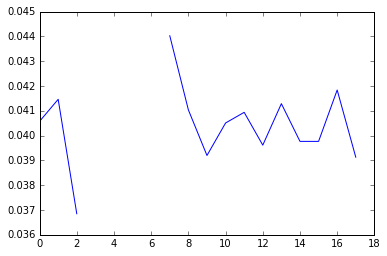

110
Best fitness: 0.04754746266975897


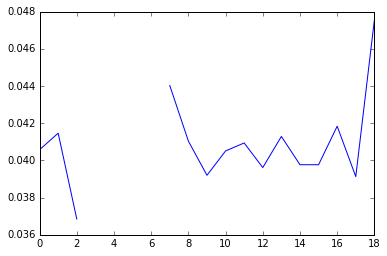

110
Best fitness: 0.03931827043579084


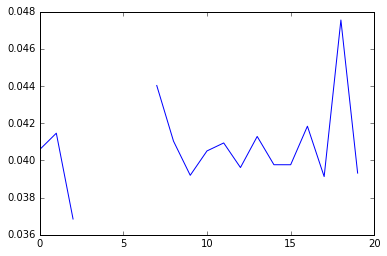

110
Best fitness: 0.034643279095938284


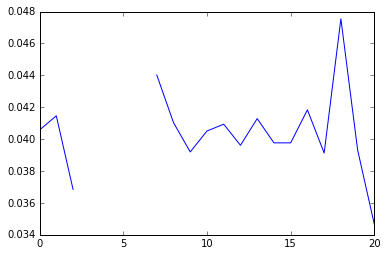

110
Best fitness: 0.03585825103049328


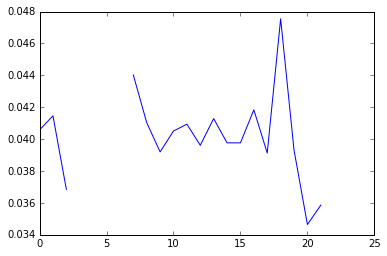

110
Best fitness: 0.04009719735916299


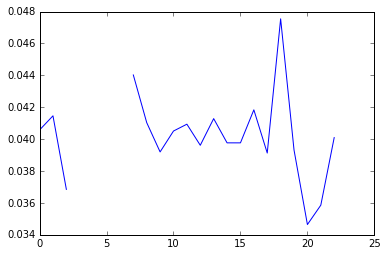

110
Best fitness: 0.04275718984745055


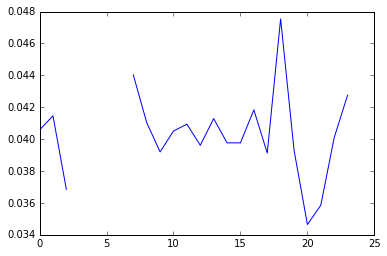

110
Best fitness: 0.04340854118080191


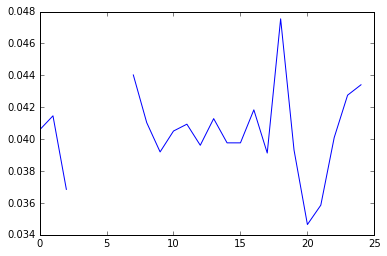

110
Best fitness: 0.04248973446049192


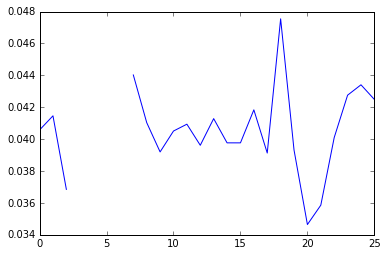

110
Best fitness: 0.03741847718380885


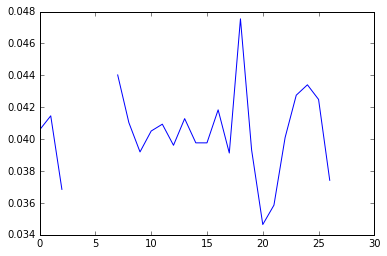

110
Best fitness: 0.03735223740378908


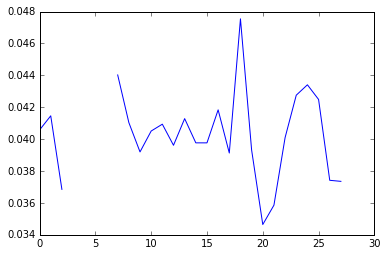

110
Best fitness: 0.0378127871706588


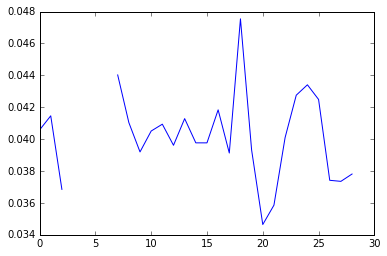

110
Best fitness: 0.03558747678008237


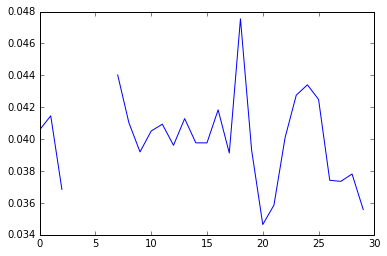

110
Best fitness: 0.0426192989719307


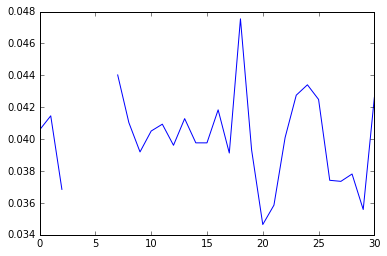

110
Best fitness: 0.03338046336390327


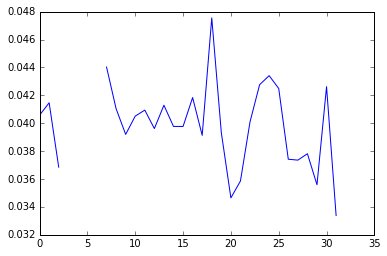

110
Best fitness: 0.03820738586644762


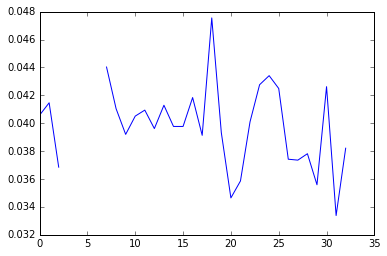

110
Best fitness: 0.035498525919726985


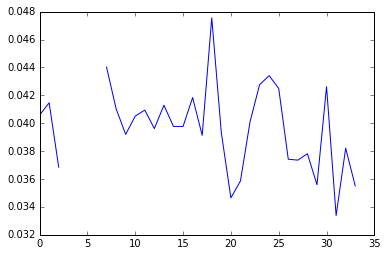

110
Best fitness: 0.03813198624886138


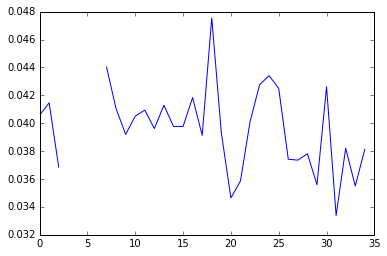

110
Best fitness: 0.03982540213734805


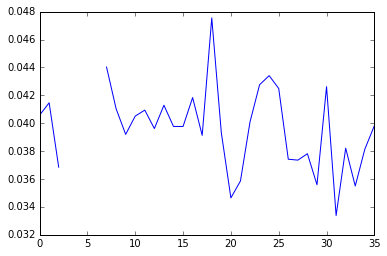

110
Best fitness: 0.03929096352319402


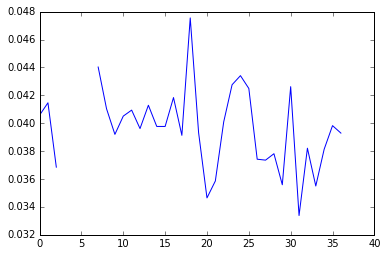

110
Best fitness: 0.04007548105394078


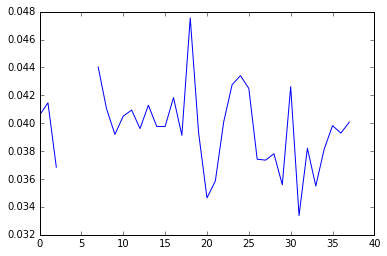

110
Best fitness: 0.037830837076825385


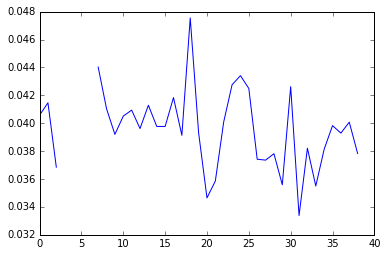

110
Best fitness: 0.039265615222248


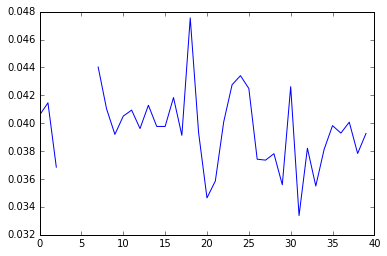

110
Best fitness: 0.039556278639259444


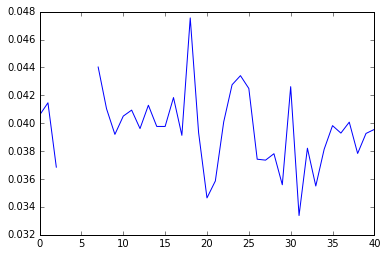

110
Best fitness: 0.03885376516882637


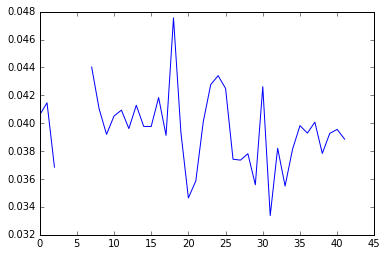

110
Best fitness: 0.036782767050565664


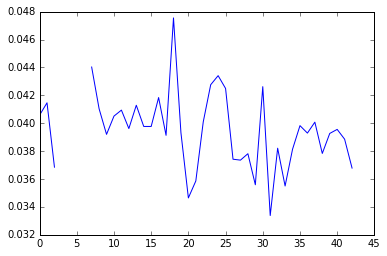

110
Best fitness: 0.04388118584780077


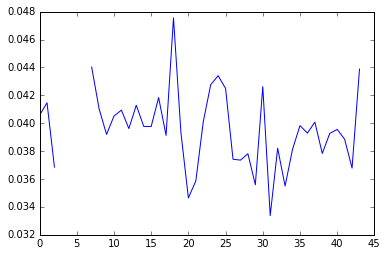

110
Best fitness: 0.04002806731796543


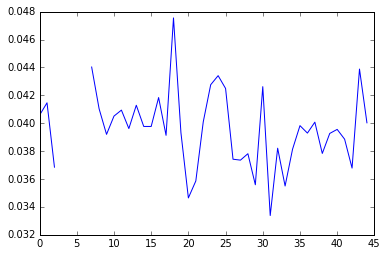

110
Best fitness: 0.04056220663595033


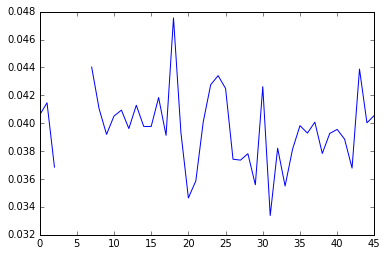

110
Best fitness: 0.03896484068037208


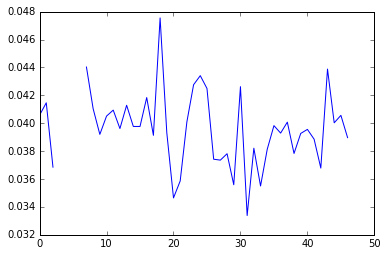

110
Best fitness: 0.03662908485855265


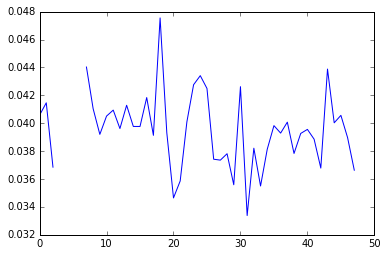

110
Best fitness: 0.04364751577285829


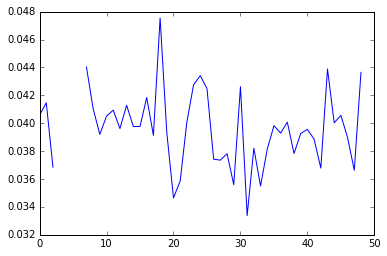

110
Best fitness: 0.0386309082326716


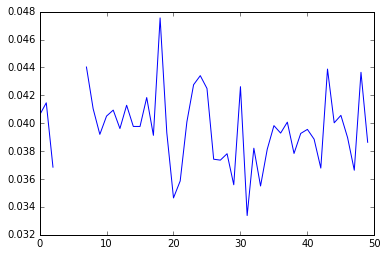

110
Best fitness: 0.04560693503023889


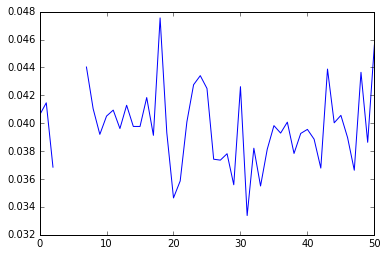

110
Best fitness: 0.03193886739822818


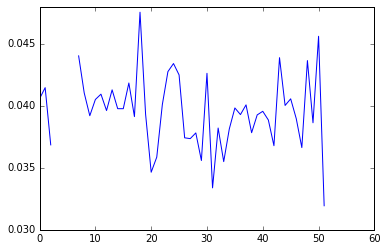

110
Best fitness: 0.04086536236453952


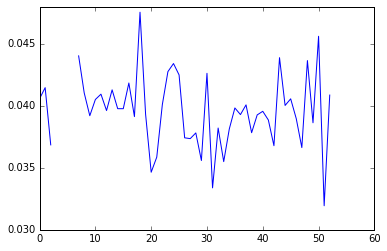

110
Best fitness: 0.035697636316083345


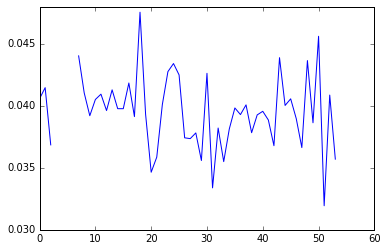

110


In [ ]:
def choose(array, indexes):
    return np.multiply(array.T, indexes).T 

def cross(being1, being2):
    indexes = np.random.choice([0, 1], size=being1.shape[0])
    return choose(being1, indexes) + choose(being2, 1 - indexes)

DELTAS = [[0, R**2], [0, 2 * pi], [0, H], None]

def mutate(being):
    next_being = being * (1 + np.random.randn(*being.shape) * 0.03)
    return next_being

def next_generation(generation):
    return [mutate(cross(being1, being2)) for being1 in generation for being2 in generation]

from multiprocessing import Pool

def sort_with_fitness(generation, fitness_function):
    print(len(generation))
    with Pool(5) as pool:
        fitnesses = pool.map(fitness_function, generation)
    sorted_zipped = sorted(zip(fitnesses, generation), key=itemgetter(0))
    sorted_beings = [being for (fitness, being) in sorted_zipped]
    sorted_fitnessess = [fitness for (fitness, being) in sorted_zipped]
    return sorted_beings, sorted_fitnessess

GEN_SIZE = 10
# generation = [np.array([ETA, OBST_CNT, O_MIN_R, O_MAX_R]) for i in range(GEN_SIZE)]
print(len(generation))

best_fitnesses = []

while True:
    sorted_generation, sorted_fitnesses = sort_with_fitness(generation, calculate_fitness)
    best_fitness = calculate_fitness(sorted_generation[0], False)
    print('Best fitness: {}'.format(best_fitness))    
    
    best_fitnesses.append(best_fitness)
    plt.plot(np.arange(len(best_fitnesses)), best_fitnesses)
    plt.show()
    
    generation = next_generation(sorted_generation[:GEN_SIZE]) + sorted_generation[:GEN_SIZE] 